In [1]:
import os, sys, glob, cv2, time
sys.path.append('..')
import numpy as np
import tensorflow as tf

from utils import *
from scipy import io as mat
from matplotlib import pyplot as plt

tf.set_random_seed(777)

In [2]:
size = 128
dep = 186

In [3]:
tmp = np.load('/data1/project/tumor/data/input/data_3d_minmax_128_186.npz')
img = tmp['img']
img = np.reshape(img, [20,dep,size,size,1])
img = img[[3, 17]]

lab = np.ceil(tmp['lab'])
lab = np.reshape(lab, [20,186,128,128,1])
lab = lab[[3, 17]]
#lab[:,:,:,:,0] = 1.-tmp_lab
#lab[:,:,:,:,1] = tmp_lab

del tmp

In [4]:
X = tf.placeholder(tf.float32, shape=[None, dep, size, size, 1])
Y = tf.placeholder(tf.float32, shape=[None, dep, size, size, 1])

In [5]:
with tf.variable_scope('variable'):

    w_en = {
        'wen1_1':init_w('wen1_1', [3,3,3,1,32]),
        'wen2_1':init_w('wen2_1', shape=[3,3,3,32,64]),
        'wen3_1':init_w('wen3_1', shape=[3,3,3,64,128]),
        'wen4_1':init_w('wen4_1', shape=[3,3,3,128,256])
    }

    w_de = {    
        'wde3_3':init_w('wde3_3', shape=[4,4,4,256,256]),
        'wde3_2':init_w('wde3_2', shape=[3,3,3,384,128]),
        'wde2_3':init_w('wde2_3', shape=[4,4,4,128,128]),
        'wde2_2':init_w('wde2_2', shape=[3,3,3,192,64]),
        'wde1_3':init_w('wde1_3', shape=[4,4,4,64,64]),
        'wde1_2':init_w('wde1_2', shape=[3,3,3,96,32]),
        'wde_out' : init_w('wde_out', shape=[3,3,3,32,1])
    }
   

In [6]:
def model(X, w_en, w_de):
    
 
    en1 = tf.nn.conv3d(X, w_en['wen1_1'], strides=[1,1,1,1,1], padding='SAME')
    en1 = tf.nn.relu(batch_norm(en1))
    print(en1)
    # 192 x 256 x 256 x 32
    pool_en1 = tf.nn.max_pool3d(en1, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')
    # 96 x 128 x 128 x 32
    print(en1)

    en2 = tf.nn.conv3d(pool_en1, w_en['wen2_1'], strides=[1,1,1,1,1], padding='SAME')
    en2 = tf.nn.relu(batch_norm(en2))
    print(en2)
    # 96 x 128 x 128 x 64
    pool_en2 = tf.nn.max_pool3d(en2, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')
    # 48 x 64 x 64 x 64
    print(en2)

    en3 = tf.nn.conv3d(pool_en2, w_en['wen3_1'], strides=[1,1,1,1,1], padding='SAME')
    en3 = tf.nn.relu(batch_norm(en3))
    print(en3)
    # 48 x 64 x 64 x 128
    pool_en3 = tf.nn.max_pool3d(en3, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')
    # 24 x 32 x 32 x 128
    print(en3)

    en4 = tf.nn.conv3d(pool_en3, w_en['wen4_1'], strides=[1,1,1,1,1], padding='SAME')
    en4 = tf.nn.relu(batch_norm(en4))
    print(en4)
    # 24 x 32 x 32 x 256

    #de3 = unpool3d(en4, en3)
    de3 = deconv3d(en4, w_de['wde3_3'],(tf.shape(X)[0], 47, 32, 32, 256),
                                strides=[1,2,2,2,1])
    print(de3)
    # 47 x 64 x 64 x 256 
    de3 = tf.concat([en3, de3], axis = 4)
    print(de3)
    # 47 x 64 x 64 x 768
    de3 = tf.nn.conv3d(de3, w_de['wde3_2'], strides=[1,1,1,1,1],padding='SAME')
    de3 = tf.nn.relu(batch_norm(de3))
    print(de3)
    # 47 x 64 x 64 x 256
    
    #de2 = unpool3d(de3, en2)
    de2 = deconv3d(de3, w_de['wde2_3'],(tf.shape(X)[0], 93, 64, 64, 128),
                                strides=[1,2,2,2,1])
    print(de2)
    # 93 x 128 x 128 x 256
    de2 = tf.concat([en2, de2], axis = 4)
    print(de2)
    # 93 x 128 x 128 x 384
    de2 = tf.nn.conv3d(de2, w_de['wde2_2'], strides=[1,1,1,1,1],padding='SAME')
    de2 = tf.nn.relu(batch_norm(de2))
    print(de2)
    # 93 x 128 x 128 x 128

    
    #de1 = unpool3d(de2, en1)
    de1 = deconv3d(de2, w_de['wde1_3'],(tf.shape(X)[0], 186, 128, 128, 64),
                                strides=[1,2,2,2,1])
    print(de1)
    # 186 x 256 x 256 x 128
    de1 = tf.concat([en1, de1], axis = 4)
    print(de1)
    # 186 x 256 x 256 x 192
    de1 = tf.nn.conv3d(de1, w_de['wde1_2'], strides=[1,1,1,1,1],padding='SAME')
    de1 = tf.nn.relu(batch_norm(de1))
    print(de1)
    # 186 x 256 x 256 x 64
    

    segment = tf.nn.conv3d(de1, w_de['wde_out'], strides=[1,1,1,1,1],padding='SAME')
    segment = tf.nn.sigmoid(50*segment)
    print(segment)
    
    
    
    
    out = {
        'en1' : en1,
        'en2' : en2,
        'en3' : en3,
        'en4' : en3,
        
        
        'de3' : de3,
        'de2' : de2,
        'de1' : de1,
        
        'seg' : segment
    }
    
    return out

In [7]:
def dice_coefficient(label, infer):
    
    label_flatten = tf.layers.flatten(label)
    infer_flatten = tf.layers.flatten(infer)
    TP = tf.reduce_sum(label_flatten*infer_flatten) + 1e-7
    FN = tf.reduce_sum(label_flatten*(1-infer_flatten)) + 1e-7
    FP = tf.reduce_sum((1-label_flatten)*infer_flatten) + 1e-7
    
    bottom = FN+FP+(2*TP) + 1e-7
    up = 2*TP + 1e-7
    return up/bottom + 1e-7

In [8]:
with tf.device('/gpu:0'):
    pred = model(X, w_en, w_de)
    coeff = dice_coefficient(Y, pred['seg'])
    cost = -coeff
with tf.device('/gpu:1'):
    train = tf.train.AdamOptimizer(1e-6).minimize(cost)

Tensor("Relu:0", shape=(?, 186, 128, 128, 32), dtype=float32, device=/device:GPU:0)
Tensor("Relu:0", shape=(?, 186, 128, 128, 32), dtype=float32, device=/device:GPU:0)
Tensor("Relu_1:0", shape=(?, 93, 64, 64, 64), dtype=float32, device=/device:GPU:0)
Tensor("Relu_1:0", shape=(?, 93, 64, 64, 64), dtype=float32, device=/device:GPU:0)
Tensor("Relu_2:0", shape=(?, 47, 32, 32, 128), dtype=float32, device=/device:GPU:0)
Tensor("Relu_2:0", shape=(?, 47, 32, 32, 128), dtype=float32, device=/device:GPU:0)
Tensor("Relu_3:0", shape=(?, 24, 16, 16, 256), dtype=float32, device=/device:GPU:0)
Tensor("add:0", shape=(?, 47, 32, 32, 256), dtype=float32, device=/device:GPU:0)
Tensor("concat:0", shape=(?, 47, 32, 32, 384), dtype=float32, device=/device:GPU:0)
Tensor("Relu_4:0", shape=(?, 47, 32, 32, 128), dtype=float32, device=/device:GPU:0)
Tensor("add_1:0", shape=(?, 93, 64, 64, 128), dtype=float32, device=/device:GPU:0)
Tensor("concat_1:0", shape=(?, 93, 64, 64, 192), dtype=float32, device=/device:GPU

In [10]:
val_coeff=[]
val_cost=[]
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
with tf.Session(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options)) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, '/data1/project/tumor/tumor3d/checkpoint/300')
    start_time = time.time()

    epochs = 1000

    batch = 1

    total_batch = int(len(img)/batch)

    for epoch in range(epochs):

        for i in range(total_batch):

            batch_idx = np.random.choice(len(img), batch, replace=False)

            batch_x = img[batch_idx]
            batch_y = lab[batch_idx]

            sess.run(train, feed_dict={X:batch_x, Y:batch_y})
            val_coeff.append(sess.run(coeff, feed_dict={X:batch_x, Y:batch_y}))
            val_cost.append(sess.run(cost, feed_dict={X:batch_x, Y:batch_y}))
                             
            if (i+1)%(total_batch/2) == 0:

                print("%d/%d"%(epoch+1, epochs))

                print("%d/%d"%(i+1, total_batch))

                print("Train cost : ", sess.run(cost, 
                                                feed_dict={X:batch_x, Y:batch_y}))
                print("Train coef : ", sess.run(coeff, 
                                                feed_dict={X:batch_x, Y:batch_y}))

                print('-----------------')

        if (epoch+1)%100 == 0:
            saver.save(sess, '/data1/project/tumor/tumor3d/checkpoint/%d'%(epoch+1))

            print('Time : ', time.time()-start_time)            

INFO:tensorflow:Restoring parameters from /data1/project/tumor/tumor3d/checkpoint/300
1/1000
1/2
Train cost :  -0.810778
Train coef :  0.810778
-----------------
1/1000
2/2
Train cost :  -0.886586
Train coef :  0.886586
-----------------
2/1000
1/2
Train cost :  -0.887172
Train coef :  0.887172
-----------------
2/1000
2/2
Train cost :  -0.887791
Train coef :  0.887791
-----------------
3/1000
1/2
Train cost :  -0.813223
Train coef :  0.813223
-----------------
3/1000
2/2
Train cost :  -0.888856
Train coef :  0.888856
-----------------
4/1000
1/2
Train cost :  -0.814412
Train coef :  0.814412
-----------------
4/1000
2/2
Train cost :  -0.88985
Train coef :  0.88985
-----------------
5/1000
1/2
Train cost :  -0.815728
Train coef :  0.815728
-----------------
5/1000
2/2
Train cost :  -0.890802
Train coef :  0.890802
-----------------
6/1000
1/2
Train cost :  -0.817142
Train coef :  0.817142
-----------------
6/1000
2/2
Train cost :  -0.818064
Train coef :  0.818064
-----------------
7/10

54/1000
1/2
Train cost :  -0.86263
Train coef :  0.86263
-----------------
54/1000
2/2
Train cost :  -0.862934
Train coef :  0.862934
-----------------
55/1000
1/2
Train cost :  -0.86328
Train coef :  0.86328
-----------------
55/1000
2/2
Train cost :  -0.86364
Train coef :  0.86364
-----------------
56/1000
1/2
Train cost :  -0.916303
Train coef :  0.916303
-----------------
56/1000
2/2
Train cost :  -0.916496
Train coef :  0.916496
-----------------
57/1000
1/2
Train cost :  -0.864282
Train coef :  0.864282
-----------------
57/1000
2/2
Train cost :  -0.864502
Train coef :  0.864502
-----------------
58/1000
1/2
Train cost :  -0.864742
Train coef :  0.864742
-----------------
58/1000
2/2
Train cost :  -0.917033
Train coef :  0.917033
-----------------
59/1000
1/2
Train cost :  -0.917206
Train coef :  0.917206
-----------------
59/1000
2/2
Train cost :  -0.865263
Train coef :  0.865263
-----------------
60/1000
1/2
Train cost :  -0.917519
Train coef :  0.917519
-----------------
60/10

Train coef :  0.928832
-----------------
107/1000
2/2
Train cost :  -0.92894
Train coef :  0.92894
-----------------
108/1000
1/2
Train cost :  -0.929053
Train coef :  0.929053
-----------------
108/1000
2/2
Train cost :  -0.929173
Train coef :  0.929173
-----------------
109/1000
1/2
Train cost :  -0.9293
Train coef :  0.9293
-----------------
109/1000
2/2
Train cost :  -0.929434
Train coef :  0.929434
-----------------
110/1000
1/2
Train cost :  -0.879827
Train coef :  0.879827
-----------------
110/1000
2/2
Train cost :  -0.929673
Train coef :  0.929673
-----------------
111/1000
1/2
Train cost :  -0.929804
Train coef :  0.929804
-----------------
111/1000
2/2
Train cost :  -0.880044
Train coef :  0.880044
-----------------
112/1000
1/2
Train cost :  -0.880173
Train coef :  0.880173
-----------------
112/1000
2/2
Train cost :  -0.880341
Train coef :  0.880341
-----------------
113/1000
1/2
Train cost :  -0.880543
Train coef :  0.880543
-----------------
113/1000
2/2
Train cost :  -0

160/1000
1/2
Train cost :  -0.936423
Train coef :  0.936423
-----------------
160/1000
2/2
Train cost :  -0.889274
Train coef :  0.889274
-----------------
161/1000
1/2
Train cost :  -0.889334
Train coef :  0.889334
-----------------
161/1000
2/2
Train cost :  -0.889404
Train coef :  0.889404
-----------------
162/1000
1/2
Train cost :  -0.93664
Train coef :  0.93664
-----------------
162/1000
2/2
Train cost :  -0.889542
Train coef :  0.889542
-----------------
163/1000
1/2
Train cost :  -0.889631
Train coef :  0.889631
-----------------
163/1000
2/2
Train cost :  -0.936774
Train coef :  0.936774
-----------------
164/1000
1/2
Train cost :  -0.936832
Train coef :  0.936832
-----------------
164/1000
2/2
Train cost :  -0.889828
Train coef :  0.889828
-----------------
165/1000
1/2
Train cost :  -0.936945
Train coef :  0.936945
-----------------
165/1000
2/2
Train cost :  -0.889951
Train coef :  0.889951
-----------------
166/1000
1/2
Train cost :  -0.890031
Train coef :  0.890031
------

Train coef :  0.941778
-----------------
213/1000
1/2
Train cost :  -0.8945
Train coef :  0.8945
-----------------
213/1000
2/2
Train cost :  -0.894553
Train coef :  0.894553
-----------------
214/1000
1/2
Train cost :  -0.941906
Train coef :  0.941906
-----------------
214/1000
2/2
Train cost :  -0.941962
Train coef :  0.941962
-----------------
215/1000
1/2
Train cost :  -0.942023
Train coef :  0.942023
-----------------
215/1000
2/2
Train cost :  -0.942086
Train coef :  0.942086
-----------------
216/1000
1/2
Train cost :  -0.942153
Train coef :  0.942153
-----------------
216/1000
2/2
Train cost :  -0.894739
Train coef :  0.894739
-----------------
217/1000
1/2
Train cost :  -0.894802
Train coef :  0.894802
-----------------
217/1000
2/2
Train cost :  -0.942312
Train coef :  0.942312
-----------------
218/1000
1/2
Train cost :  -0.942376
Train coef :  0.942376
-----------------
218/1000
2/2
Train cost :  -0.894955
Train coef :  0.894955
-----------------
219/1000
1/2
Train cost :  

265/1000
2/2
Train cost :  -0.899776
Train coef :  0.899776
-----------------
266/1000
1/2
Train cost :  -0.899867
Train coef :  0.899867
-----------------
266/1000
2/2
Train cost :  -0.945838
Train coef :  0.945838
-----------------
267/1000
1/2
Train cost :  -0.945882
Train coef :  0.945882
-----------------
267/1000
2/2
Train cost :  -0.900048
Train coef :  0.900048
-----------------
268/1000
1/2
Train cost :  -0.945964
Train coef :  0.945964
-----------------
268/1000
2/2
Train cost :  -0.900146
Train coef :  0.900146
-----------------
269/1000
1/2
Train cost :  -0.900203
Train coef :  0.900203
-----------------
269/1000
2/2
Train cost :  -0.900265
Train coef :  0.900265
-----------------
270/1000
1/2
Train cost :  -0.946091
Train coef :  0.946091
-----------------
270/1000
2/2
Train cost :  -0.946134
Train coef :  0.946134
-----------------
271/1000
1/2
Train cost :  -0.946183
Train coef :  0.946183
-----------------
271/1000
2/2
Train cost :  -0.900426
Train coef :  0.900426
----

Train coef :  0.90565
-----------------
318/1000
2/2
Train cost :  -0.905737
Train coef :  0.905737
-----------------
319/1000
1/2
Train cost :  -0.905813
Train coef :  0.905813
-----------------
319/1000
2/2
Train cost :  -0.905873
Train coef :  0.905873
-----------------
320/1000
1/2
Train cost :  -0.949678
Train coef :  0.949678
-----------------
320/1000
2/2
Train cost :  -0.949694
Train coef :  0.949694
-----------------
321/1000
1/2
Train cost :  -0.949716
Train coef :  0.949716
-----------------
321/1000
2/2
Train cost :  -0.949742
Train coef :  0.949742
-----------------
322/1000
1/2
Train cost :  -0.905957
Train coef :  0.905957
-----------------
322/1000
2/2
Train cost :  -0.949798
Train coef :  0.949798
-----------------
323/1000
1/2
Train cost :  -0.949833
Train coef :  0.949833
-----------------
323/1000
2/2
Train cost :  -0.906049
Train coef :  0.906049
-----------------
324/1000
1/2
Train cost :  -0.906076
Train coef :  0.906076
-----------------
324/1000
2/2
Train cost 

371/1000
1/2
Train cost :  -0.952442
Train coef :  0.952442
-----------------
371/1000
2/2
Train cost :  -0.908659
Train coef :  0.908659
-----------------
372/1000
1/2
Train cost :  -0.908692
Train coef :  0.908692
-----------------
372/1000
2/2
Train cost :  -0.952488
Train coef :  0.952488
-----------------
373/1000
1/2
Train cost :  -0.908768
Train coef :  0.908768
-----------------
373/1000
2/2
Train cost :  -0.952521
Train coef :  0.952521
-----------------
374/1000
1/2
Train cost :  -0.908871
Train coef :  0.908871
-----------------
374/1000
2/2
Train cost :  -0.952554
Train coef :  0.952554
-----------------
375/1000
1/2
Train cost :  -0.952576
Train coef :  0.952576
-----------------
375/1000
2/2
Train cost :  -0.952601
Train coef :  0.952601
-----------------
376/1000
1/2
Train cost :  -0.908967
Train coef :  0.908967
-----------------
376/1000
2/2
Train cost :  -0.952649
Train coef :  0.952649
-----------------
377/1000
1/2
Train cost :  -0.95268
Train coef :  0.95268
------

Train coef :  0.954847
-----------------
424/1000
1/2
Train cost :  -0.954879
Train coef :  0.954879
-----------------
424/1000
2/2
Train cost :  -0.910951
Train coef :  0.910951
-----------------
425/1000
1/2
Train cost :  -0.954935
Train coef :  0.954935
-----------------
425/1000
2/2
Train cost :  -0.91099
Train coef :  0.91099
-----------------
426/1000
1/2
Train cost :  -0.911015
Train coef :  0.911015
-----------------
426/1000
2/2
Train cost :  -0.911036
Train coef :  0.911036
-----------------
427/1000
1/2
Train cost :  -0.955017
Train coef :  0.955017
-----------------
427/1000
2/2
Train cost :  -0.95504
Train coef :  0.95504
-----------------
428/1000
1/2
Train cost :  -0.911074
Train coef :  0.911074
-----------------
428/1000
2/2
Train cost :  -0.955082
Train coef :  0.955082
-----------------
429/1000
1/2
Train cost :  -0.911103
Train coef :  0.911103
-----------------
429/1000
2/2
Train cost :  -0.955125
Train coef :  0.955125
-----------------
430/1000
1/2
Train cost :  

476/1000
2/2
Train cost :  -0.957013
Train coef :  0.957013
-----------------
477/1000
1/2
Train cost :  -0.957032
Train coef :  0.957032
-----------------
477/1000
2/2
Train cost :  -0.913281
Train coef :  0.913281
-----------------
478/1000
1/2
Train cost :  -0.91329
Train coef :  0.91329
-----------------
478/1000
2/2
Train cost :  -0.95708
Train coef :  0.95708
-----------------
479/1000
1/2
Train cost :  -0.913311
Train coef :  0.913311
-----------------
479/1000
2/2
Train cost :  -0.957107
Train coef :  0.957107
-----------------
480/1000
1/2
Train cost :  -0.957122
Train coef :  0.957122
-----------------
480/1000
2/2
Train cost :  -0.913369
Train coef :  0.913369
-----------------
481/1000
1/2
Train cost :  -0.957147
Train coef :  0.957147
-----------------
481/1000
2/2
Train cost :  -0.913442
Train coef :  0.913442
-----------------
482/1000
1/2
Train cost :  -0.91349
Train coef :  0.91349
-----------------
482/1000
2/2
Train cost :  -0.913525
Train coef :  0.913525
----------

529/1000
2/2
Train cost :  -0.958478
Train coef :  0.958478
-----------------
530/1000
1/2
Train cost :  -0.914943
Train coef :  0.914943
-----------------
530/1000
2/2
Train cost :  -0.958517
Train coef :  0.958517
-----------------
531/1000
1/2
Train cost :  -0.958538
Train coef :  0.958538
-----------------
531/1000
2/2
Train cost :  -0.958558
Train coef :  0.958558
-----------------
532/1000
1/2
Train cost :  -0.95858
Train coef :  0.95858
-----------------
532/1000
2/2
Train cost :  -0.958601
Train coef :  0.958601
-----------------
533/1000
1/2
Train cost :  -0.91498
Train coef :  0.91498
-----------------
533/1000
2/2
Train cost :  -0.915005
Train coef :  0.915005
-----------------
534/1000
1/2
Train cost :  -0.958648
Train coef :  0.958648
-----------------
534/1000
2/2
Train cost :  -0.915032
Train coef :  0.915032
-----------------
535/1000
1/2
Train cost :  -0.958676
Train coef :  0.958676
-----------------
535/1000
2/2
Train cost :  -0.915066
Train coef :  0.915066
--------

Train coef :  0.91702
-----------------
582/1000
2/2
Train cost :  -0.917068
Train coef :  0.917068
-----------------
583/1000
1/2
Train cost :  -0.91713
Train coef :  0.91713
-----------------
583/1000
2/2
Train cost :  -0.917228
Train coef :  0.917228
-----------------
584/1000
1/2
Train cost :  -0.95967
Train coef :  0.95967
-----------------
584/1000
2/2
Train cost :  -0.959676
Train coef :  0.959676
-----------------
585/1000
1/2
Train cost :  -0.917396
Train coef :  0.917396
-----------------
585/1000
2/2
Train cost :  -0.959689
Train coef :  0.959689
-----------------
586/1000
1/2
Train cost :  -0.917481
Train coef :  0.917481
-----------------
586/1000
2/2
Train cost :  -0.917517
Train coef :  0.917517
-----------------
587/1000
1/2
Train cost :  -0.917548
Train coef :  0.917548
-----------------
587/1000
2/2
Train cost :  -0.95971
Train coef :  0.95971
-----------------
588/1000
1/2
Train cost :  -0.959719
Train coef :  0.959719
-----------------
588/1000
2/2
Train cost :  -0.

635/1000
1/2
Train cost :  -0.961196
Train coef :  0.961196
-----------------
635/1000
2/2
Train cost :  -0.919812
Train coef :  0.919812
-----------------
636/1000
1/2
Train cost :  -0.961221
Train coef :  0.961221
-----------------
636/1000
2/2
Train cost :  -0.961234
Train coef :  0.961234
-----------------
637/1000
1/2
Train cost :  -0.961246
Train coef :  0.961246
-----------------
637/1000
2/2
Train cost :  -0.961259
Train coef :  0.961259
-----------------
638/1000
1/2
Train cost :  -0.919825
Train coef :  0.919825
-----------------
638/1000
2/2
Train cost :  -0.919828
Train coef :  0.919828
-----------------
639/1000
1/2
Train cost :  -0.961287
Train coef :  0.961287
-----------------
639/1000
2/2
Train cost :  -0.919832
Train coef :  0.919832
-----------------
640/1000
1/2
Train cost :  -0.919834
Train coef :  0.919834
-----------------
640/1000
2/2
Train cost :  -0.919837
Train coef :  0.919837
-----------------
641/1000
1/2
Train cost :  -0.919841
Train coef :  0.919841
----

Train coef :  0.920771
-----------------
688/1000
1/2
Train cost :  -0.920775
Train coef :  0.920775
-----------------
688/1000
2/2
Train cost :  -0.92078
Train coef :  0.92078
-----------------
689/1000
1/2
Train cost :  -0.962094
Train coef :  0.962094
-----------------
689/1000
2/2
Train cost :  -0.962107
Train coef :  0.962107
-----------------
690/1000
1/2
Train cost :  -0.962123
Train coef :  0.962123
-----------------
690/1000
2/2
Train cost :  -0.962141
Train coef :  0.962141
-----------------
691/1000
1/2
Train cost :  -0.96216
Train coef :  0.96216
-----------------
691/1000
2/2
Train cost :  -0.920811
Train coef :  0.920811
-----------------
692/1000
1/2
Train cost :  -0.962193
Train coef :  0.962193
-----------------
692/1000
2/2
Train cost :  -0.962211
Train coef :  0.962211
-----------------
693/1000
1/2
Train cost :  -0.962229
Train coef :  0.962229
-----------------
693/1000
2/2
Train cost :  -0.920877
Train coef :  0.920877
-----------------
694/1000
1/2
Train cost :  

740/1000
2/2
Train cost :  -0.922231
Train coef :  0.922231
-----------------
741/1000
1/2
Train cost :  -0.922235
Train coef :  0.922235
-----------------
741/1000
2/2
Train cost :  -0.922243
Train coef :  0.922243
-----------------
742/1000
1/2
Train cost :  -0.96311
Train coef :  0.96311
-----------------
742/1000
2/2
Train cost :  -0.922266
Train coef :  0.922266
-----------------
743/1000
1/2
Train cost :  -0.922282
Train coef :  0.922282
-----------------
743/1000
2/2
Train cost :  -0.922296
Train coef :  0.922296
-----------------
744/1000
1/2
Train cost :  -0.922309
Train coef :  0.922309
-----------------
744/1000
2/2
Train cost :  -0.963143
Train coef :  0.963143
-----------------
745/1000
1/2
Train cost :  -0.922335
Train coef :  0.922335
-----------------
745/1000
2/2
Train cost :  -0.922347
Train coef :  0.922347
-----------------
746/1000
1/2
Train cost :  -0.922353
Train coef :  0.922353
-----------------
746/1000
2/2
Train cost :  -0.963165
Train coef :  0.963165
------

Train coef :  0.963835
-----------------
793/1000
2/2
Train cost :  -0.923558
Train coef :  0.923558
-----------------
794/1000
1/2
Train cost :  -0.923576
Train coef :  0.923576
-----------------
794/1000
2/2
Train cost :  -0.963849
Train coef :  0.963849
-----------------
795/1000
1/2
Train cost :  -0.923596
Train coef :  0.923596
-----------------
795/1000
2/2
Train cost :  -0.963862
Train coef :  0.963862
-----------------
796/1000
1/2
Train cost :  -0.963871
Train coef :  0.963871
-----------------
796/1000
2/2
Train cost :  -0.963879
Train coef :  0.963879
-----------------
797/1000
1/2
Train cost :  -0.963887
Train coef :  0.963887
-----------------
797/1000
2/2
Train cost :  -0.923681
Train coef :  0.923681
-----------------
798/1000
1/2
Train cost :  -0.923697
Train coef :  0.923697
-----------------
798/1000
2/2
Train cost :  -0.963899
Train coef :  0.963899
-----------------
799/1000
1/2
Train cost :  -0.963905
Train coef :  0.963905
-----------------
799/1000
2/2
Train cost

846/1000
1/2
Train cost :  -0.9646
Train coef :  0.9646
-----------------
846/1000
2/2
Train cost :  -0.964608
Train coef :  0.964608
-----------------
847/1000
1/2
Train cost :  -0.964617
Train coef :  0.964617
-----------------
847/1000
2/2
Train cost :  -0.924765
Train coef :  0.924765
-----------------
848/1000
1/2
Train cost :  -0.96463
Train coef :  0.96463
-----------------
848/1000
2/2
Train cost :  -0.964636
Train coef :  0.964636
-----------------
849/1000
1/2
Train cost :  -0.964641
Train coef :  0.964641
-----------------
849/1000
2/2
Train cost :  -0.964647
Train coef :  0.964647
-----------------
850/1000
1/2
Train cost :  -0.964653
Train coef :  0.964653
-----------------
850/1000
2/2
Train cost :  -0.924772
Train coef :  0.924772
-----------------
851/1000
1/2
Train cost :  -0.924781
Train coef :  0.924781
-----------------
851/1000
2/2
Train cost :  -0.924802
Train coef :  0.924802
-----------------
852/1000
1/2
Train cost :  -0.964671
Train coef :  0.964671
----------

Train coef :  0.925248
-----------------
899/1000
1/2
Train cost :  -0.965218
Train coef :  0.965218
-----------------
899/1000
2/2
Train cost :  -0.965229
Train coef :  0.965229
-----------------
900/1000
1/2
Train cost :  -0.965242
Train coef :  0.965242
-----------------
900/1000
2/2
Train cost :  -0.965256
Train coef :  0.965256
-----------------
901/1000
1/2
Train cost :  -0.965269
Train coef :  0.965269
-----------------
901/1000
2/2
Train cost :  -0.925279
Train coef :  0.925279
-----------------
902/1000
1/2
Train cost :  -0.925303
Train coef :  0.925303
-----------------
902/1000
2/2
Train cost :  -0.965294
Train coef :  0.965294
-----------------
903/1000
1/2
Train cost :  -0.925328
Train coef :  0.925328
-----------------
903/1000
2/2
Train cost :  -0.925341
Train coef :  0.925341
-----------------
904/1000
1/2
Train cost :  -0.965308
Train coef :  0.965308
-----------------
904/1000
2/2
Train cost :  -0.925377
Train coef :  0.925377
-----------------
905/1000
1/2
Train cost

951/1000
2/2
Train cost :  -0.965578
Train coef :  0.965578
-----------------
952/1000
1/2
Train cost :  -0.925692
Train coef :  0.925692
-----------------
952/1000
2/2
Train cost :  -0.965583
Train coef :  0.965583
-----------------
953/1000
1/2
Train cost :  -0.965587
Train coef :  0.965587
-----------------
953/1000
2/2
Train cost :  -0.965594
Train coef :  0.965594
-----------------
954/1000
1/2
Train cost :  -0.925714
Train coef :  0.925714
-----------------
954/1000
2/2
Train cost :  -0.965606
Train coef :  0.965606
-----------------
955/1000
1/2
Train cost :  -0.925736
Train coef :  0.925736
-----------------
955/1000
2/2
Train cost :  -0.965613
Train coef :  0.965613
-----------------
956/1000
1/2
Train cost :  -0.965615
Train coef :  0.965615
-----------------
956/1000
2/2
Train cost :  -0.925745
Train coef :  0.925745
-----------------
957/1000
1/2
Train cost :  -0.965618
Train coef :  0.965618
-----------------
957/1000
2/2
Train cost :  -0.965621
Train coef :  0.965621
----

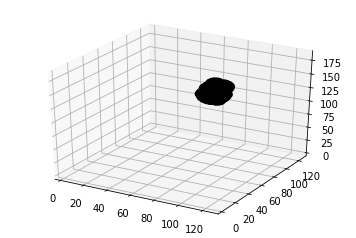

INFO:tensorflow:Restoring parameters from /data1/project/tumor/tumor3d/checkpoint/1000


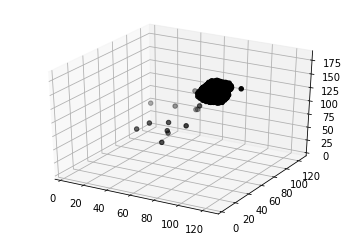

In [15]:
num = 0
plot_3d(lab[num][:,:,:])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, '/data1/project/tumor/tumor3d/checkpoint/1000')
    result = sess.run(pred, feed_dict={X:np.reshape(img[num], [1,dep,size,size,1])})['seg']
    plot_3d(result[0,:,:,:])
    #plot_3d(np.uint16(sess.run(pred, feed_dict={X:np.reshape(img[num], [1,dep,size,size,1])})['seg'][0,:,:,:,0]))
    #print(sess.run(pred, feed_dict={X:np.reshape(img[num], [1,dep,size,size,1])})['seg'][0,:,:,:])

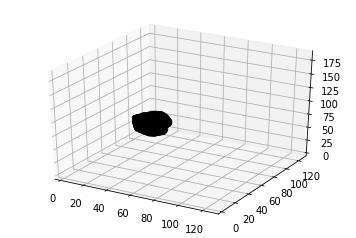

INFO:tensorflow:Restoring parameters from /data1/project/tumor/tumor3d/checkpoint/1000


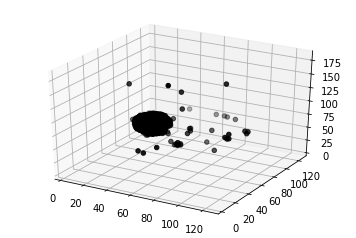

In [14]:
num = 1
plot_3d(lab[num][:,:,:])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, '/data1/project/tumor/tumor3d/checkpoint/1000')
    result = sess.run(pred, feed_dict={X:np.reshape(img[num], [1,dep,size,size,1])})['seg']
    plot_3d(result[0,:,:,:])
    #plot_3d(np.uint16(sess.run(pred, feed_dict={X:np.reshape(img[num], [1,dep,size,size,1])})['seg'][0,:,:,:,0]))
    #print(sess.run(pred, feed_dict={X:np.reshape(img[num], [1,dep,size,size,1])})['seg'][0,:,:,:])